# FAQ Chatbot для Викиучебника

## 1. Установка зависимостей

In [ ]:
!pip install pandas numpy sentence-transformers scikit-learn requests
!pip install matplotlib seaborn plotly

## 2. Импорт библиотек

In [11]:
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

sys.path.append('..')

## 3. Подготовка данных

### 3.1 Загрузка и обработка исходных данных

Загружено 30 записей

Первые 5 записей:


,question,answer,source,alternative_questions
0,Можно ли размещать сторонние тексты в Викиучеб...,Текст может быть размещён в русском Викиучебни...,Авторские права,Как добавить чужой текст в Викиучебник?;Можно ...
1,В каких целях разрешено использовать тексты из...,"Разрешено распространение, изменение и использ...",Авторские права,Как можно использовать материалы Викиучебника?...
2,Какие лицензии применяются к текстам на Викиуч...,"Лицензии CC BY-SA 4.0 и GFDL, по которым публи...",Авторские права,Под какой лицензией выходит контент Викиучебни...
3,Можно ли копировать текст из других статей в с...,При копировании текстов из других статей Викиу...,Авторские права,Как правильно скопировать текст из другой стат...
4,Какая ответсвенность за нарушение авторских прав?,За нарушение авторских прав правилами Викиучеб...,Авторские права,Что будет за нарушение авторских прав в Викиуч...



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   question               30 non-null     object
 1   answer                 30 non-null     object
 2   source                 30 non-null     object
 3   alternative_questions  30 non-null     object
dtypes: object(4)
memory usage: 1.1+ KB


None

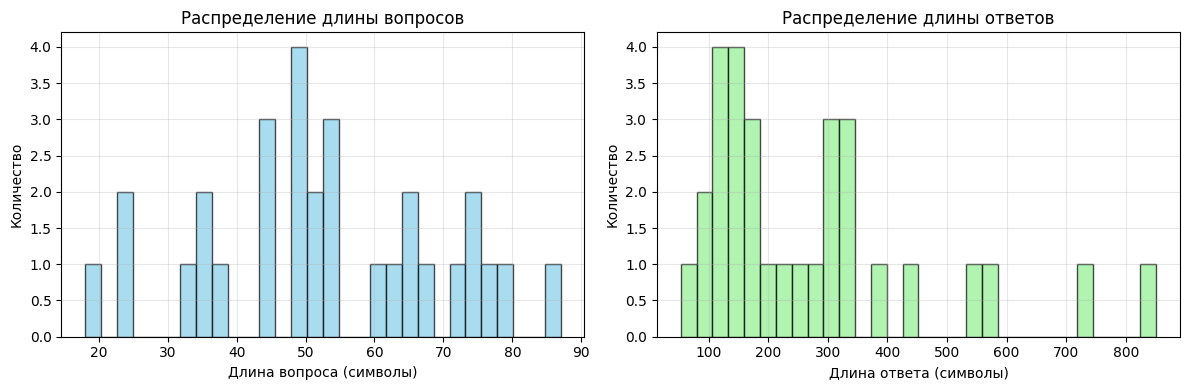

In [12]:
# Создаем папку для данных если её нет
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

# Загружаем исходные данные
df = pd.read_csv('data/ruwikibooks_rules.csv') if os.path.exists('data/ruwikibooks_rules.csv') else None

if df is not None:
    print(f"Загружено {len(df)} записей")
    print("\nПервые 5 записей:")
    display(df.head())

    print("\nИнформация о данных:")
    display(df.info())

    # Визуализация: распределение длины вопросов
    df['question_length'] = df['question'].str.len()
    df['answer_length'] = df['answer'].str.len()

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].hist(df['question_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0].set_xlabel('Длина вопроса (символы)')
    axes[0].set_ylabel('Количество')
    axes[0].set_title('Распределение длины вопросов')
    axes[0].grid(True, alpha=0.3)

    axes[1].hist(df['answer_length'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1].set_xlabel('Длина ответа (символы)')
    axes[1].set_ylabel('Количество')
    axes[1].set_title('Распределение длины ответов')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("Файл данных не найден. Пожалуйста, загрузите ruwikibooks_rules.csv в папку data/")

### 3.2 Расширение данных (альтернативные вопросы)

Запускаем подготовку данных:

Расширенный набор данных: 90 записей


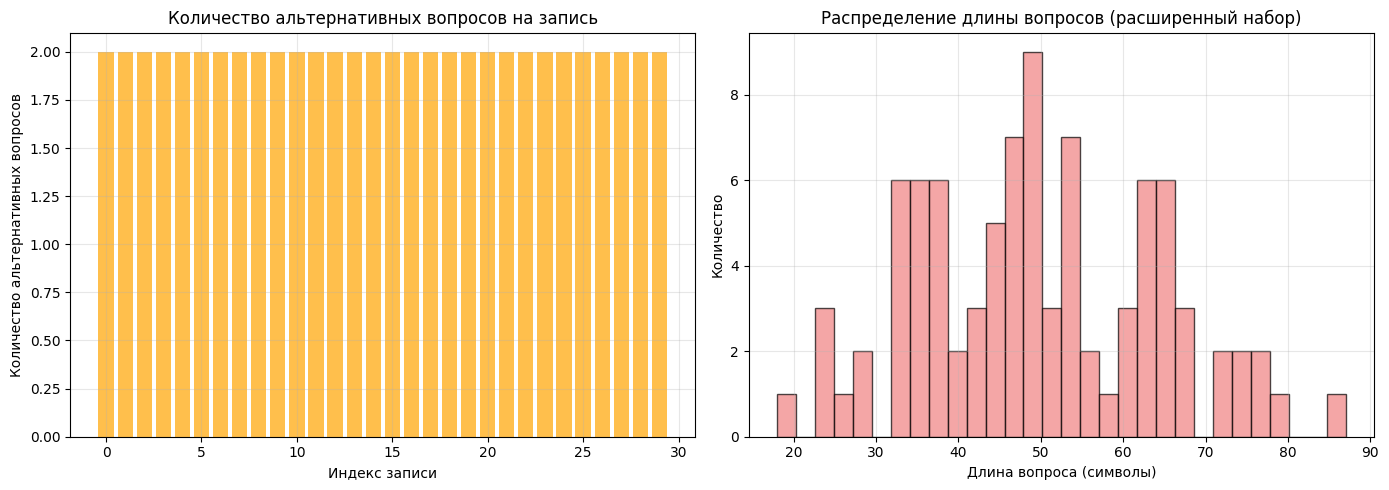


Примеры расширенных данных:

1. Вопрос: Что значит быстрого удаления?...
   Ответ (начало): В некоторых случаях администраторы могут удалять страницы Викиучебника без предварительного уведомле...

2. Вопрос: Какое максимальное количество несвободных изображений на странице?...
   Ответ (начало): Количество несвободных медиа-файлов на одной странице должно быть минимальным. Если для её иллюстрац...

3. Вопрос: Что считается рекламой в Викиучебнике?...
   Ответ (начало): Страница, целиком состоящая из рекламы или продвигающая товары, услуги, организации, требующая полно...

4. Вопрос: По каким причинам удаляют файлы?...
   Ответ (начало): Критерии удаления для файлов
Ф1. Точная или ухудшенная копия
Ф2. Повреждённый или пустой файл
Ф3....

5. Вопрос: Можно ли размещать сторонние тексты в Викиучебнике?...
   Ответ (начало): Текст может быть размещён в русском Викиучебнике только при выполнении одного из следующих условий:
...


In [13]:
from src.data_preparation import prepare_data

# Если файл еще не создан, обрабатываем данные
if not os.path.exists('expanded_rules.csv'):
    prepare_data()

# Загружаем расширенные данные
faq_df = pd.read_csv('data/expanded_rules.csv')
print(f"Расширенный набор данных: {len(faq_df)} записей")

# Визуализация: сравнение оригинальных и расширенных данных
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Количество альтернативных вопросов на оригинальный
if 'df' in locals() and df is not None:
    alt_counts = df['alternative_questions'].apply(
        lambda x: len(str(x).split(';')) if pd.notna(x) else 0
    )

    axes[0].bar(range(len(alt_counts)), alt_counts.values, alpha=0.7, color='orange')
    axes[0].set_xlabel('Индекс записи')
    axes[0].set_ylabel('Количество альтернативных вопросов')
    axes[0].set_title('Количество альтернативных вопросов на запись')
    axes[0].grid(True, alpha=0.3)

# Распределение вопросов по длине в расширенном наборе
faq_df['length'] = faq_df['question'].str.len()
axes[1].hist(faq_df['length'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Длина вопроса (символы)')
axes[1].set_ylabel('Количество')
axes[1].set_title('Распределение длины вопросов (расширенный набор)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Показать примеры расширенных данных
print("\nПримеры расширенных данных:")
sample_data = faq_df.sample(5, random_state=42)
for i, (_, row) in enumerate(sample_data.iterrows()):
    print(f"\n{i+1}. Вопрос: {row['question'][:80]}...")
    print(f"   Ответ (начало): {row['answer'][:100]}...")

## 4. Векторизация и семантический поиск

### 4.1 Инициализация модели векторизации

Инициализация модели векторизации...
Данные загружены:
                                            question  \
0  Можно ли размещать сторонние тексты в Викиучеб...   
1            Как добавить чужой текст в Викиучебник?   
2  Можно ли копировать текст из других источников...   
3  В каких целях разрешено использовать тексты из...   
4     Как можно использовать материалы Викиучебника?   

                                              answer  
0  Текст может быть размещён в русском Викиучебни...  
1  Текст может быть размещён в русском Викиучебни...  
2  Текст может быть размещён в русском Викиучебни...  
3  Разрешено распространение, изменение и использ...  
4  Разрешено распространение, изменение и использ...  
                                             question  \
85                 Нужно ли ставить подпись в статье?   
86            Где нужно подписываться в Викиучебнике?   
87      Когда можно блокировать новичка за нарушения?   
88                В каких случаях блокируют новичк

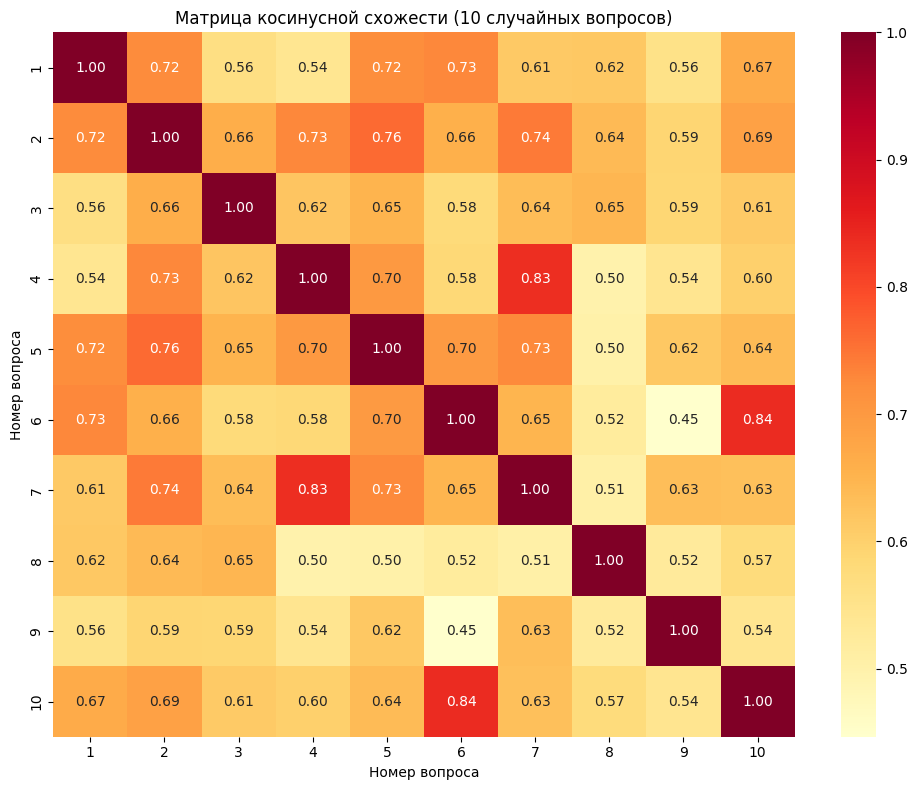

In [14]:
from embeding import Embedder, load_data, load_embeddings, find_top_similar_questions

# Инициализируем эмбеддер
print("Инициализация модели векторизации...")
embedder = Embedder()

# Загружаем данные
df = load_data('data/expanded_rules.csv')
questions = np.array(df['question'])

# Создаем или загружаем эмбеддинги
path = 'question_embeddings.npy'
if os.path.exists(path):
    print("Загрузка предварительно вычисленных эмбеддингов...")
    question_embeddings = load_embeddings(path)
else:
    print("Вычисление эмбеддингов для всех вопросов...")
    question_embeddings = embedder.embed(questions)
    np.save('question_embeddings.npy', question_embeddings)
    print(f"Эмбеддинги сохранены в {path}")

# Визуализация размерности эмбеддингов
print(f"\nРазмерность эмбеддингов: {question_embeddings.shape}")

# Визуализация: тепловая карта схожести для нескольких примеров
if len(questions) > 5:
    sample_indices = np.random.choice(len(questions), 10, replace=False)
    sample_questions = questions[sample_indices]
    sample_embeddings = question_embeddings[sample_indices]

    # Вычисляем матрицу схожести
    from sklearn.metrics.pairwise import cosine_similarity
    similarity_matrix = cosine_similarity(sample_embeddings)

    # Визуализируем
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix,
                annot=True,
                fmt='.2f',
                cmap='YlOrRd',
                xticklabels=range(1, 11),
                yticklabels=range(1, 11))
    plt.title('Матрица косинусной схожести (10 случайных вопросов)')
    plt.xlabel('Номер вопроса')
    plt.ylabel('Номер вопроса')
    plt.tight_layout()
    plt.show()

### 4.2 Тестирование семантического поиска

#### Тест 1/5

### Вопрос пользователя: *Почему удалили учебник?*


**🟢 Результат 12 (схожесть: 100.0%)**

**Вопрос из базы:** Почему удалили учебник?

**Ответ:** Критерии удаления для страниц учебника
Уч1. Пустой или очень короткий учебник без «учебного» содержания
Уч2. Учебник не на русском языке
Уч3. Учебник состоит только из ссылок
Уч4. Страница является статьей из других проектов
Уч5. Учебник без доказательств значимости
Уч7. Копия существующего учебника...
        

--------------------------------------------------------------------------------



**🟡 Результат 19 (схожесть: 76.1%)**

**Вопрос из базы:** Почему удалили страницу?

**Ответ:** Общие критерии быстрого удаления
О1. Бессвязное содержимое
О2. Тестовая страница
О3. Страница для вандализма
О4. Точная копия ранее удалённой страницы
О5. Удаление запросил единственный автор
О6. Обсуждение удалённой страницы
О7. Для возможности переименования
О8. Копия существующей страницы
О9. Рек...
        

--------------------------------------------------------------------------------



**🟡 Результат 11 (схожесть: 73.1%)**

**Вопрос из базы:** Почему не работает перенаправление?

**Ответ:** Критерии удаления для перенаправлений
П1. Перенаправление на несуществующую страницу
П2. Перенаправление между пространствами имён
П3. Перенаправление с ошибкой в названии
П4. Название не в именительном падеже
П5. Семантически некорректное перенаправление
П6. Перенаправление на страницу обсужд...
        

--------------------------------------------------------------------------------


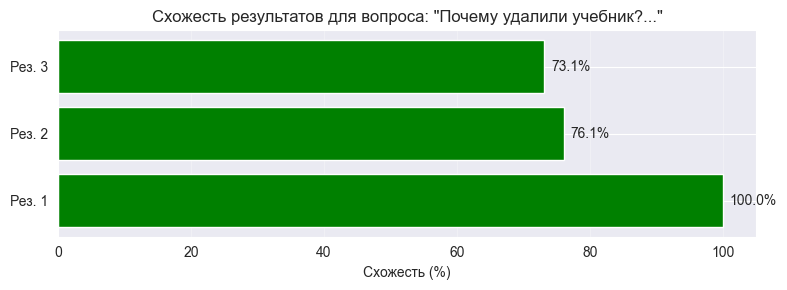


----------------------------------------------------------------------------------------------------



#### Тест 2/5

### Вопрос пользователя: *Как удалить учебник новичка?*


**🟡 Результат 26 (схожесть: 79.1%)**

**Вопрос из базы:** Как следует относиться к новичкам в Викиучебнике?

**Ответ:** Уважительно: помогать, не критиковать, не оскорблять, объяснять принципы работы. Нарушения новичков не следует пресекать блокировками без предупреждений....
        

--------------------------------------------------------------------------------



**🟡 Результат 12 (схожесть: 75.1%)**

**Вопрос из базы:** Почему удалили учебник?

**Ответ:** Критерии удаления для страниц учебника
Уч1. Пустой или очень короткий учебник без «учебного» содержания
Уч2. Учебник не на русском языке
Уч3. Учебник состоит только из ссылок
Уч4. Страница является статьей из других проектов
Уч5. Учебник без доказательств значимости
Уч7. Копия существующего учебника...
        

--------------------------------------------------------------------------------



**🟡 Результат 4 (схожесть: 72.1%)**

**Вопрос из базы:** Как подписываться в тексте учебника?

**Ответ:** В тексте учебника подписываться не нужно — авторы правок видны в истории изменений. Подписываться нужно только на страницах обсуждений....
        

--------------------------------------------------------------------------------


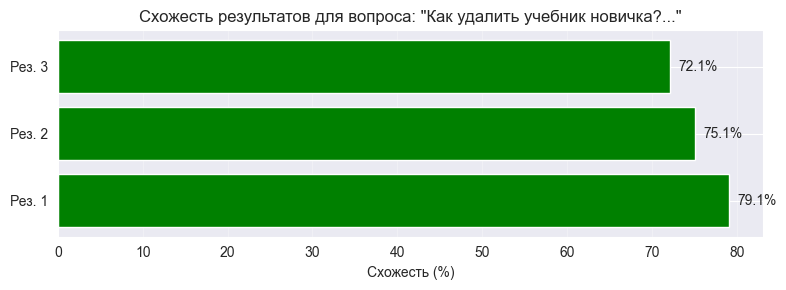


----------------------------------------------------------------------------------------------------



#### Тест 3/5

### Вопрос пользователя: *Какие правила оформления статей?*


**🟡 Результат 3 (схожесть: 75.9%)**

**Вопрос из базы:** Что такое критерии быстрого удаления в Викиучебнике?

**Ответ:** В некоторых случаях администраторы могут удалять страницы Викиучебника без предварительного уведомления, даже если эти страницы были вынесены на обсуждение. Ниже перечислены все такие случаи. Список является исчерпывающим и расширительному толкованию не подлежит....
        

--------------------------------------------------------------------------------



**🟡 Результат 8 (схожесть: 75.1%)**

**Вопрос из базы:** Как использование несвободного материала влияет на его коммерческую ценность?

**Ответ:** Использование несвободного материала не должно уменьшать коммерческую ценность исходного произведения, либо заменять его приобретение....
        

--------------------------------------------------------------------------------



**🟡 Результат 2 (схожесть: 70.0%)**

**Вопрос из базы:** В каких случаях администраторы могут удалять страницы без предварительного уведомления?

**Ответ:** Администраторы могут удалять страницы без уведомления только в случаях, перечисленных в Критериях быстрого удаления. Этот список является исчерпывающим и не подлежит расширительному толкованию....
        

--------------------------------------------------------------------------------


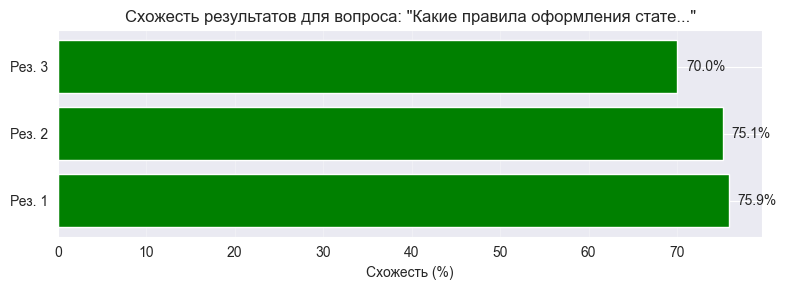


----------------------------------------------------------------------------------------------------



#### Тест 4/5

### Вопрос пользователя: *Что делать если мой контент удалили?*


**🟡 Результат 5 (схожесть: 74.8%)**

**Вопрос из базы:** Можно ли удалить страницу, если этого хочет её единственный автор?

**Ответ:** Да, если удаление запросил единственный автор и причины либо очевидны, либо явно указаны....
        

--------------------------------------------------------------------------------



**🟡 Результат 19 (схожесть: 71.0%)**

**Вопрос из базы:** Почему удалили страницу?

**Ответ:** Общие критерии быстрого удаления
О1. Бессвязное содержимое
О2. Тестовая страница
О3. Страница для вандализма
О4. Точная копия ранее удалённой страницы
О5. Удаление запросил единственный автор
О6. Обсуждение удалённой страницы
О7. Для возможности переименования
О8. Копия существующей страницы
О9. Рек...
        

--------------------------------------------------------------------------------



**🟡 Результат 12 (схожесть: 69.3%)**

**Вопрос из базы:** Почему удалили учебник?

**Ответ:** Критерии удаления для страниц учебника
Уч1. Пустой или очень короткий учебник без «учебного» содержания
Уч2. Учебник не на русском языке
Уч3. Учебник состоит только из ссылок
Уч4. Страница является статьей из других проектов
Уч5. Учебник без доказательств значимости
Уч7. Копия существующего учебника...
        

--------------------------------------------------------------------------------


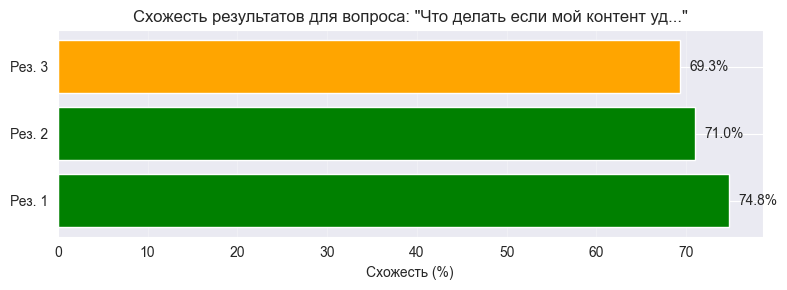


----------------------------------------------------------------------------------------------------



#### Тест 5/5

### Вопрос пользователя: *Как найти книгу про нейронные сети?*


**🟡 Результат 11 (схожесть: 69.0%)**

**Вопрос из базы:** Почему не работает перенаправление?

**Ответ:** Критерии удаления для перенаправлений
П1. Перенаправление на несуществующую страницу
П2. Перенаправление между пространствами имён
П3. Перенаправление с ошибкой в названии
П4. Название не в именительном падеже
П5. Семантически некорректное перенаправление
П6. Перенаправление на страницу обсужд...
        

--------------------------------------------------------------------------------



**🟡 Результат 27 (схожесть: 68.9%)**

**Вопрос из базы:** Как запросить удаление страницы?

**Ответ:** Участники, не являющиеся администраторами, могут запросить удаление страниц, поставив в их начале шаблон: {{К быстрому удалению|причина}} или {{delete|причина}}, или {{d|причина}}, или один из специализированных шаблонов....
        

--------------------------------------------------------------------------------



**🟡 Результат 14 (схожесть: 68.6%)**

**Вопрос из базы:** Какие лицензии применяются к текстам на Викиучебнике?

**Ответ:** Лицензии CC BY-SA 4.0 и GFDL, по которым публикуются и распространяются текстовые материалы русского Викиучебника....
        

--------------------------------------------------------------------------------


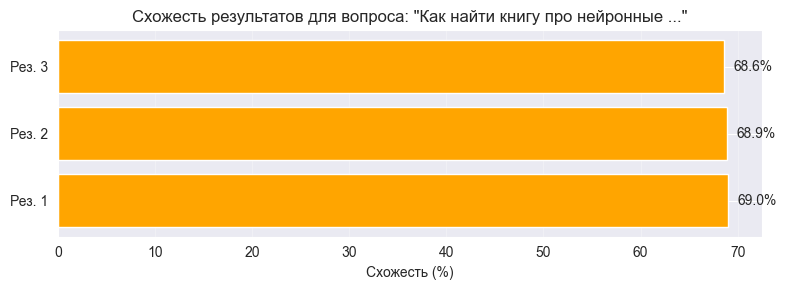


----------------------------------------------------------------------------------------------------



In [10]:
# Функция для отображения результатов поиска
def display_search_results(user_question, top_results, df):
    display(Markdown(f"### Вопрос пользователя: *{user_question}*"))

    for idx, row in top_results.iterrows():
        similarity_percent = row['similarity'] * 100

        # Цветовая индикация по схожести
        if similarity_percent > 80:
            color = "🟢"
        elif similarity_percent > 60:
            color = "🟡"
        else:
            color = "🔴"

        display(Markdown(f"""
**{color} Результат {idx+1} (схожесть: {similarity_percent:.1f}%)**

**Вопрос из базы:** {row['question']}

**Ответ:** {row['answer'][:300]}...
        """))
        print("-" * 80)

# Тестовые вопросы для демонстрации
test_questions = [
    "Почему удалили учебник?",
    "Как удалить учебник новичка?",
    "Какие правила оформления статей?",
    "Что делать если мой контент удалили?",
    "Как найти книгу про нейронные сети?"
]

# Тестируем каждый вопрос
for i, test_q in enumerate(test_questions):
    display(Markdown(f"#### Тест {i+1}/{len(test_questions)}"))

    top_results = find_top_similar_questions(
        test_q,
        df,
        question_embeddings,
        embedder,
        top_n=3
    )

    display_search_results(test_q, top_results, df)

    # Добавляем небольшой график схожести для наглядности
    if not top_results.empty:
        plt.figure(figsize=(8, 3))
        bars = plt.barh(range(len(top_results)), top_results['similarity'].values * 100,
                       color=['green' if x > 70 else 'orange' if x > 50 else 'red'
                              for x in top_results['similarity'].values * 100])

        plt.xlabel('Схожесть (%)')
        plt.yticks(range(len(top_results)), [f'Рез. {i+1}' for i in range(len(top_results))])
        plt.title(f'Схожесть результатов для вопроса: "{test_q[:30]}..."')
        plt.grid(True, alpha=0.3, axis='x')

        # Добавляем значения на столбцы
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 1, bar.get_y() + bar.get_height()/2,
                    f'{width:.1f}%', va='center')

        plt.tight_layout()
        plt.show()

    print("\n" + "-"*100 + "\n")

## 5. Интеграция с LLM (Gemma 3)

### 5.1 Настройка API ключа

In [15]:
# Устанавливаем API ключ OpenRouter
import os
os.environ['OPENROUTER_API_KEY'] = "Ваш ключ OpenRouter"

### 5.2 Тестирование LLM-улучшения

In [16]:
from src.LLM import generate_rag_response

In [18]:
# Тестируем улучшение ответов через LLM
test_cases = [
    "Почему удалили учебник?",
    "Как удалить учебник новичка?",
    "Какие правила оформления статей?",
    "Что делать если мой контент удалили?",
    "Как найти книгу про нейронные сети?"
]

for i, question in enumerate(test_cases):
    display(Markdown(f"### Тест LLM {i+1}/{len(test_cases)}"))

    # Получаем семантические результаты
    top_results = find_top_similar_questions(
        question,
        df,
        question_embeddings,
        embedder,
        top_n=3
    )

    # Генерируем RAG ответ
    response = generate_rag_response(question, top_results, use_llm=True)

    # Отображаем результаты
    display(Markdown(f"#### Вопрос: **{question}**"))

    if response['status'] == 'success':
        # Базовый ответ
        display(Markdown("""
<div style="background-color: #e0f0ff; padding: 15px; border-radius: 5px; margin: 10px 0;">
<h4>Базовый ответ (семантический поиск)</h4>
"""))
        display(Markdown(f"**Уверенность:** {response['confidence']:.2%}"))
        display(Markdown(f"**Ответ:** {response['full_answer']}"))
        display(Markdown("</div>"))

        # LLM улучшенный ответ
        if 'llm_enhanced' in response:
            display(Markdown("""
<div style="background-color: #e0f0ff; padding: 15px; border-radius: 5px; margin: 10px 0;">
<h4> Улучшенный ответ (Gemma 3)</h4>
"""))
            display(Markdown(response['llm_enhanced']))
            display(Markdown("</div>"))

            # Статистика использования контекста
            if 'context_used' in response:
                display(Markdown(f"*Использовано контекстов: {response['context_used']}*"))
    else:
        display(Markdown(f"{response['message']}"))

    print("\n" + "-"*100 + "\n")

### Тест LLM 1/5

[DEBUG] Использовано токенов: 2392


#### Вопрос: **Почему удалили учебник?**


<div style="background-color: #e0f0ff; padding: 15px; border-radius: 5px; margin: 10px 0;">
<h4>Базовый ответ (семантический поиск)</h4>


**Уверенность:** 100.00%

**Ответ:** Критерии удаления для страниц учебника
Уч1. Пустой или очень короткий учебник без «учебного» содержания
Уч2. Учебник не на русском языке
Уч3. Учебник состоит только из ссылок
Уч4. Страница является статьей из других проектов
Уч5. Учебник без доказательств значимости
Уч7. Копия существующего учебника

</div>


<div style="background-color: #e0f0ff; padding: 15px; border-radius: 5px; margin: 10px 0;">
<h4> Улучшенный ответ (Gemma 3)</h4>


Учебник мог быть удален по нескольким причинам, связанным с его содержанием, языком, значимостью или дублированием.

Детали:

1.  **Пустое или очень короткое содержание:** Учебник был удален, если он был пуст или содержал слишком мало информации, не соответствующей учебному материалу (Уч1).
2.  **Не на русском языке:** Учебники, написанные не на русском языке, подлежат удалению (Уч2).
3.  **Только ссылки:** Если учебник состоял исключительно из ссылок, он мог быть удален (Уч3).
4.  **Копия из других проектов:** Страницы, являющиеся статьями из других проектов, удаляются (Уч4).
5.  **Отсутствие значимости:** Учебник мог быть удален, если не было представлено доказательств его значимости (Уч5).
6.  **Дублирование:** Учебник, являющийся копией существующего учебника, также подлежит удалению (Уч7).

</div>

*Использовано контекстов: 3*


----------------------------------------------------------------------------------------------------



### Тест LLM 2/5

[DEBUG] Использовано токенов: 2184


#### Вопрос: **Как удалить учебник новичка?**


<div style="background-color: #e0f0ff; padding: 15px; border-radius: 5px; margin: 10px 0;">
<h4>Базовый ответ (семантический поиск)</h4>


**Уверенность:** 79.10%

**Ответ:** Уважительно: помогать, не критиковать, не оскорблять, объяснять принципы работы. Нарушения новичков не следует пресекать блокировками без предупреждений.

</div>


<div style="background-color: #e0f0ff; padding: 15px; border-radius: 5px; margin: 10px 0;">
<h4> Улучшенный ответ (Gemma 3)</h4>


В предоставленных материалах есть информация о критериях удаления учебников, но нет инструкций о том, как именно это сделать, особенно в отношении учебников новичков.

Детали:

1.  **Критерии удаления учебника:** Согласно предоставленным материалам, учебник может быть удален, если он:
    *   Пустой или очень короткий и не содержит учебного содержания (Уч1).
    *   Написан не на русском языке (Уч2).
    *   Состоит только из ссылок (Уч3).
    *   Является копией статьи из других проектов (Уч4).
    *   Не имеет доказательств значимости (Уч5).
    *   Является копией существующего учебника (Уч7).

2.  **Отношение к новичкам:** Важно помнить, что к новичкам следует относиться уважительно, помогать им и объяснять принципы работы Викиучебника (Источник 1). Нарушения новичков не следует пресекать блокировками без предупреждений (Источник 1).

В предоставленных материалах нет информации о процедуре удаления учебника или о том, кто имеет право это делать.

</div>

*Использовано контекстов: 3*


----------------------------------------------------------------------------------------------------



### Тест LLM 3/5

[DEBUG] Использовано токенов: 2135


#### Вопрос: **Какие правила оформления статей?**


<div style="background-color: #e0f0ff; padding: 15px; border-radius: 5px; margin: 10px 0;">
<h4>Базовый ответ (семантический поиск)</h4>


**Уверенность:** 75.86%

**Ответ:** В некоторых случаях администраторы могут удалять страницы Викиучебника без предварительного уведомления, даже если эти страницы были вынесены на обсуждение. Ниже перечислены все такие случаи. Список является исчерпывающим и расширительному толкованию не подлежит.

</div>


<div style="background-color: #e0f0ff; padding: 15px; border-radius: 5px; margin: 10px 0;">
<h4> Улучшенный ответ (Gemma 3)</h4>


В предоставленных материалах нет полной информации по этому вопросу.

Контекст содержит информацию о:

1.  **Критериях быстрого удаления:** Администраторы могут удалять страницы без предварительного уведомления в случаях, перечисленных в этих критериях. Список является исчерпывающим.
2.  **Использовании несвободного материала:** Использование такого материала не должно уменьшать коммерческую ценность исходного произведения или заменять его приобретение.
3.  **Удалении страниц администраторами:** Администраторы могут удалять страницы без уведомления только при наличии оснований, указанных в Критериях быстрого удаления.

В предоставленных материалах нет информации о правилах оформления статей в Викиучебнике.

</div>

*Использовано контекстов: 3*


----------------------------------------------------------------------------------------------------



### Тест LLM 4/5

[DEBUG] Использовано токенов: 2675


#### Вопрос: **Что делать если мой контент удалили?**


<div style="background-color: #e0f0ff; padding: 15px; border-radius: 5px; margin: 10px 0;">
<h4>Базовый ответ (семантический поиск)</h4>


**Уверенность:** 74.77%

**Ответ:** Да, если удаление запросил единственный автор и причины либо очевидны, либо явно указаны.

</div>


<div style="background-color: #e0f0ff; padding: 15px; border-radius: 5px; margin: 10px 0;">
<h4> Улучшенный ответ (Gemma 3)</h4>


В предоставленных материалах есть информация о причинах удаления страниц, как обычных, так и учебников.

Детали:

*   **Удаление по запросу автора:** Страница может быть удалена, если об этом попросил её единственный автор, и причины удаления очевидны или указаны (Источник 1, О5 в Источнике 2).
*   **Общие критерии быстрого удаления:** Страницы могут быть удалены по следующим причинам (Источник 2):
    *   Бессвязное содержимое (О1)
    *   Тестовая страница (О2)
    *   Страница для вандализма (О3)
    *   Точная копия ранее удалённой страницы (О4)
    *   Обсуждение удалённой страницы (О6)
    *   Для возможности переименования (О7)
    *   Копия существующей страницы (О8)
    *   Реклама, спам (О9)
    *   Нецелевое использование страницы обсуждения (О10)
    *   Явное нарушение авторских прав (О11)
*   **Критерии удаления для учебников:** Учебники могут быть удалены по следующим причинам (Источник 3):
    *   Пустой или очень короткий учебник без «учебного» содержания (Уч1)
    *   Учебник не на русском языке (Уч2)
    *   Учебник состоит только из ссылок (Уч3)
    *   Страница является статьей из других проектов (Уч4)
    *   Учебник без доказательств значимости (Уч5)
    *   Копия существующего учебника (Уч7)

В предоставленных материалах нет информации о том, *что делать*, если ваш контент уже удалили. Есть только перечень причин, по которым контент может быть удален.

</div>

*Использовано контекстов: 3*


----------------------------------------------------------------------------------------------------



### Тест LLM 5/5

[DEBUG] Использовано токенов: 2131


#### Вопрос: **Как найти книгу про нейронные сети?**


<div style="background-color: #e0f0ff; padding: 15px; border-radius: 5px; margin: 10px 0;">
<h4>Базовый ответ (семантический поиск)</h4>


**Уверенность:** 69.01%

**Ответ:** Критерии удаления для перенаправлений
П1. Перенаправление на несуществующую страницу
П2. Перенаправление между пространствами имён
П3. Перенаправление с ошибкой в названии
П4. Название не в именительном падеже
П5. Семантически некорректное перенаправление
П6. Перенаправление на страницу обсуждения

</div>


<div style="background-color: #e0f0ff; padding: 15px; border-radius: 5px; margin: 10px 0;">
<h4> Улучшенный ответ (Gemma 3)</h4>


В предоставленных материалах нет полной информации по этому вопросу.

Контекст содержит информацию о:

1.  **Критериях удаления перенаправлений:** Перенаправления могут быть удалены, если они ведут на несуществующие страницы, между пространствами имён, содержат ошибки в названии, используют неименительный падеж, являются семантически некорректными или ведут на страницы обсуждения.
2.  **Процедуре запроса удаления страниц:** Участники, не являющиеся администраторами, могут запросить удаление страниц с помощью шаблонов {{К быстрому удалению|причина}}, {{delete|причина}}, {{d|причина}} или специализированных шаблонов.
3.  **Лицензиях на тексты:** Тексты на Викиучебнике публикуются под лицензиями CC BY-SA 4.0 и GFDL.

Ни один из этих источников не содержит информации о том, как найти книгу про нейронные сети на Викиучебнике.

</div>

*Использовано контекстов: 3*


----------------------------------------------------------------------------------------------------



## 6 Попробуйте задать свой вопрос

Свободный помощник - помогает отвечать на вопросы о Викиучебнике, даже если не получает правил, дающих четкий ответ.

Строгий помощник (отключение свободного помощника) - дает только описанную в правилах информацию.

### Примеры вопросов:
    "Почему удалили учебник?" - вопрос из базы
    "Как удалить учебник новичка?" - есть похожие вопросы
    "Что делать если мой контент удалили?" - есть похожие вопросы
    "Какие правила оформления статей?" - нет ответа в базе
    "Как найти книгу про нейронные сети?" - нет ответа в базе
    "Как пригласить тебя в кино?" - вопрос не по теме

In [19]:
from ipywidgets import widgets, Layout, VBox, HBox, Output
from IPython.display import display, clear_output

# Создаем виджеты
question_input = widgets.Textarea(
    value='',
    placeholder='Введите ваш вопрос о правилах Викиучебника...',
    description='Вопрос:',
    layout=Layout(width='80%', height='100px'),
    disabled=False
)

search_button = widgets.Button(
    description='Найти ответ',
    button_style='primary',
    layout=Layout(width='200px', height='40px')
)

use_llm_checkbox = widgets.Checkbox(
    value=True,
    description='Использовать LLM-улучшение',
    disabled=False
)

creative_answer_checkbox = widgets.Checkbox(
    value=True,
    description='Свободный помощник',
    disabled=False
)

output_area = Output()

def on_search_button_clicked(b):
    with output_area:
        clear_output(wait=True)

        if not question_input.value.strip():
            print("Пожалуйста, введите вопрос.")
            return

        # Показываем индикатор загрузки
        display(Markdown("**Поиск ответа...**"))

        # Получаем семантические результаты
        start_time = time.time()
        top_results = find_top_similar_questions(
            question_input.value,
            df,
            question_embeddings,
            embedder,
            top_n=5
        )
        search_time = time.time() - start_time

        # Генерируем ответ
        if not top_results.empty:
            display(Markdown(f"*Время поиска: {search_time:.2f} сек*"))

            if use_llm_checkbox.value:
                # С LLM улучшением
                display(Markdown("### Генерация улучшенного ответа..."))
                start_llm_time = time.time()
                response = generate_rag_response(
                    question_input.value,
                    top_results,
                    use_llm=True,
                    creative_answer=creative_answer_checkbox.value
                )
                llm_time = time.time() - start_llm_time

                if response['status'] == 'success':
                    if 'llm_enhanced' in response:
                        display(Markdown("### Улучшенный ответ"))
                        display(Markdown(response['llm_enhanced']))
                        display(Markdown(f"*Время генерации: {llm_time:.2f} сек*"))
                    else:
                        display(Markdown("### Лучший найденный ответ"))
                        display(Markdown(response['full_answer']))
                else:
                    display(Markdown(f"**{response['message']}**"))
            else:
                display_search_results(question_input.value, top_results.head(3), df)
        else:
            display(Markdown("### Ответ не найден"))
            display(Markdown("К сожалению, в базе знаний нет информации по вашему вопросу."))
            display(Markdown("Попробуйте переформулировать вопрос или задать его по-другому."))

search_button.on_click(on_search_button_clicked)

# Отображаем интерфейс
display(VBox([
    widgets.HTML("<h2>FAQ Чат-бот Викиучебника</h2>"),
    question_input,
    HBox([search_button, use_llm_checkbox, creative_answer_checkbox]),
    output_area
]))

## 7. Анализ производительности

### 7.1 Оценка скорости работы

[DEBUG] Использовано токенов: 2197


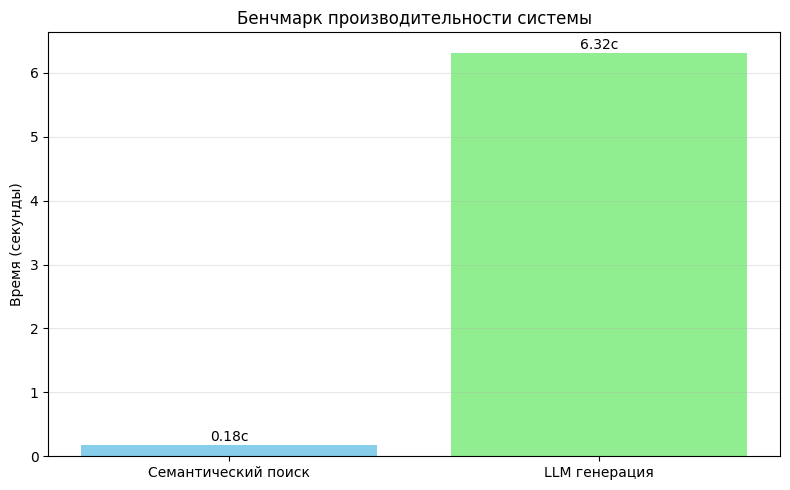

 Результаты бенчмарка:
  Семантический поиск: 0.18 секунд
  LLM генерация: 6.32 секунд


In [20]:
import time

# Тестируем скорость разных компонентов
def benchmark_system():
    results = {}

    # 1. Скорость семантического поиска
    test_question = "Как удалить учебник новичка?"

    start_time = time.time()
    top_results = find_top_similar_questions(
        test_question,
        df,
        question_embeddings,
        embedder,
        top_n=5
    )
    results['semantic_search'] = time.time() - start_time

    # 2. Скорость LLM-генерации (если есть ключ API)
    if top_results.empty or not os.environ.get('OPENROUTER_API_KEY'):
        results['llm_generation'] = None
    else:
        try:
            start_time = time.time()
            response = generate_rag_response(test_question, top_results, use_llm=True)
            results['llm_generation'] = time.time() - start_time
        except:
            results['llm_generation'] = None

    return results

benchmark_results = benchmark_system()

# Визуализация результатов
fig, ax = plt.subplots(figsize=(8, 5))

components = ['Семантический поиск']
times = [benchmark_results['semantic_search']]

if benchmark_results['llm_generation']:
    components.append('LLM генерация')
    times.append(benchmark_results['llm_generation'])

bars = ax.bar(components, times, color=['skyblue', 'lightgreen'])
ax.set_ylabel('Время (секунды)')
ax.set_title('Бенчмарк производительности системы')
ax.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.2f}с', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(" Результаты бенчмарка:")
for component, t in zip(components, times):
    print(f"  {component}: {t:.2f} секунд")

In [21]:
display(Markdown("""
<div style="background-color: #e0f0ff; padding: 20px; border-radius: 5px; margin: 20px 0;">
<h2> Система готова к использованию!</h2>

<h3>Основные компоненты:</h3>
<ul>
<li> База знаний: {faq_count} вопросов-ответов</li>
<li> Семантический поиск: модель all-MiniLM-L6-v2</li>
<li> LLM-улучшение: Gemma 3 через OpenRouter</li>
<li> Среднее время ответа: {search_time:.2f} сек</li>
</ul>

<h3>Быстрый старт:</h3>
<pre><code># Импорт функций
from embeding import find_top_similar_questions
from LLM import generate_rag_response</code></pre>

<pre><code># Поиск ответа
question = "Ваш вопрос"
results = find_top_similar_questions(question, df, question_embeddings, embedder)
response = generate_rag_response(question, results, use_llm=True)</code></pre>

<pre><code># Вывод
if 'llm_enhanced' in response:
    display(Markdown(response['llm_enhanced']))
else:
    display(Markdown(response['full_answer']))
</div>
""".format(
    faq_count=len(faq_df),
    search_time=benchmark_results['semantic_search']
)))




<div style="background-color: #e0f0ff; padding: 20px; border-radius: 5px; margin: 20px 0;">
<h2> Система готова к использованию!</h2>

<h3>Основные компоненты:</h3>
<ul>
<li> База знаний: 90 вопросов-ответов</li>
<li> Семантический поиск: модель all-MiniLM-L6-v2</li>
<li> LLM-улучшение: Gemma 3 через OpenRouter</li>
<li> Среднее время ответа: 0.18 сек</li>
</ul>

<h3>Быстрый старт:</h3>
<pre><code># Импорт функций
from embeding import find_top_similar_questions
from LLM import generate_rag_response</code></pre>

<pre><code># Поиск ответа
question = "Ваш вопрос"
results = find_top_similar_questions(question, df, question_embeddings, embedder)
response = generate_rag_response(question, results, use_llm=True)</code></pre>

<pre><code># Вывод
if 'llm_enhanced' in response:
    display(Markdown(response['llm_enhanced']))
else:
    display(Markdown(response['full_answer']))
</div>


In [22]:
from embeding import find_top_similar_questions
from src.LLM import generate_rag_response

question = "Как тебя зовут?"
results = find_top_similar_questions(question, df, question_embeddings, embedder)
response = generate_rag_response(question, results, use_llm=True)
if 'llm_enhanced' in response:
    display(Markdown(response['llm_enhanced']))
else:
    display(Markdown(response['full_answer']))

[DEBUG] Использовано токенов: 1799


В предоставленных материалах нет полной информации по этому вопросу.

Детали:

1.  Предоставленные источники содержат информацию о правилах редактирования и поведения в Викиучебнике, а именно:
    *   О том, как и где подписываться.
    *   О случаях блокировки пользователей.
    *   О соблюдении авторских прав при копировании текста.
2.  В этих источниках отсутствует информация об имени или назначении помощника-эксперта.